### Approach 1 :- training on predefined ImageNet Model and fine tuning it 

we unfreeze the last few layers so gradients update (fine-tuning).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2025-09-11 16:27:16.141113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757608036.348228      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757608036.405416      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

test_dir  = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test"
train_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train"
val_dir   = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val"

img_size = (224, 224)
batch_size = 32
num_classes = 8


### Data Augmentation

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    zoom_range=0.1,          
    shear_range=0.05,        # mild shearing
    horizontal_flip=True,    # OCT can be flipped left-right(OCT scans shouldn’t flip upside down)
    fill_mode="nearest"zasZA
)

train_gen = datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", shuffle=False
)


Found 18400 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


In [5]:
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


# Approach 1 using fine tuned VGG19 with ImageNet weights

In [11]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))

In [12]:
# Fine-tune last few layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(num_classes, activation="softmax")(x)

In [13]:
model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,028,488 (76.40 MB)

 Trainable params: 7,083,528 (27.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)


* EarlyStopping → stop when validation loss stops improving, avoid overfitting.
* ModelCheckpoint → save the best model weights.
* ReduceLROnPlateau → reduce learning rate if validation loss stalls.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Adding a bit of callbacks for better efficiency 
early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

checkpoint = ModelCheckpoint(
    "best_vgg19_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=3, verbose=1, min_lr=1e-6
)

## Training the model for approach 1

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,               # earlystopping can handle the overfitting part , hence increased the epochs 
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6363 - loss: 0.9756
Epoch 1: val_accuracy improved from -inf to 0.91250, saving model to best_vgg19_model.h5
575/575 ━━━━━━━━━━━━━━━━━━━━ 290s 494ms/step - accuracy: 0.6365 - loss: 0.9749 - val_accuracy: 0.9125 - val_loss: 0.2599 - learning_rate: 1.0000e-04
Epoch 2/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9067 - loss: 0.2641
Epoch 2: val_accuracy improved from 0.91250 to 0.93250, saving model to best_vgg19_model.h5
575/575 ━━━━━━━━━━━━━━━━━━━━ 261s 453ms/step - accuracy: 0.9067 - loss: 0.2641 - val_accuracy: 0.9325 - val_loss: 0.1978 - learning_rate: 1.0000e-04
Epoch 3/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9295 - loss: 0.2081
Epoch 3: val_accuracy did not improve from 0.93250
575/575 ━━━━━━━━━━━━━━━━━━━━ 267s 465ms/step - accuracy: 0.9295 - loss: 0.2081 - val_accuracy: 0.9293 - val_loss: 0.2073 - learning_rate: 1.0000e-04
Epoch 4/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - a

## Evaluating the model ( Fine tuned VGG )


88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.9630 - loss: 0.1006
Fine-tuned VGG19 Test Accuracy: 0.9532
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step


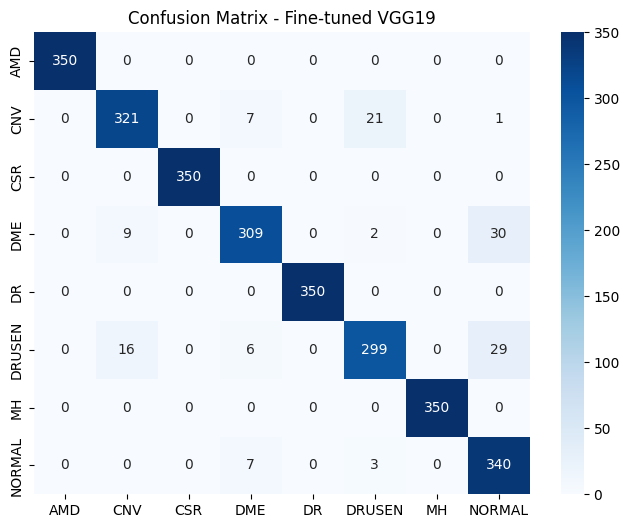

In [16]:
loss, acc = model.evaluate(test_gen)
print(f"Fine-tuned VGG19 Test Accuracy: {acc:.4f}")

# Confusion Matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned VGG19")
plt.show()


# Approach 2 :- Feature Extraction with VGG19 and adding classic ML classifiers : SVM / random forest 

We load VGG19 with ImageNet weights.

* include_top=False → removes the classification head, so we only keep the convolutional base.

* pooling="avg" → applies GlobalAveragePooling2D at the end, giving us a 512-dim feature vector per image.

* By default, all layers in this model are non-trainable because we are only calling .predict() on it — we never call .fit().

In [6]:
# Extracting the features from the VGG model and then freezing the classification layer and using ML models like SVM and random forest hence only the ML part is trained 
feature_model = VGG19(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))

# Extract features
X_train = feature_model.predict(train_gen, verbose=1)
X_val   = feature_model.predict(val_gen, verbose=1)
X_test  = feature_model.predict(test_gen, verbose=1)

y_train = train_gen.classes
y_val   = val_gen.classes
y_test  = test_gen.classes

print("Feature shapes:", X_train.shape, X_val.shape, X_test.shape)


I0000 00:00:1757608134.997395      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757608139.719357     118 service.cc:148] XLA service 0x7faa8400b330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757608139.720341     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757608139.899143     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/575 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step  

I0000 00:00:1757608147.641516     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


575/575 ━━━━━━━━━━━━━━━━━━━━ 397s 677ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 431ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step
Feature shapes: (18400, 512) (2800, 512) (2800, 512)


## **SVM**

In [16]:
svm = SVC(kernel="rbf", probability=True)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=class_names))


SVM Accuracy: 0.08142857142857143
              precision    recall  f1-score   support

         AMD       0.00      0.01      0.00       350
         CNV       0.01      0.00      0.00       350
         CSR       0.00      0.00      0.00       350
         DME       0.08      0.21      0.12       350
          DR       0.04      0.01      0.01       350
      DRUSEN       0.06      0.06      0.06       350
          MH       0.13      0.14      0.13       350
      NORMAL       0.27      0.23      0.24       350

    accuracy                           0.08      2800
   macro avg       0.08      0.08      0.07      2800
weighted avg       0.08      0.08      0.07      2800



**As we can see the accuracy reports are ~8% even less than that of random guessing which might be ~12.5 % ( for 8 classes )**

**Embeddings too high-dimensional**


* VGG19 gives 512 or 4096-dimensional features depending on the layer.
* SVM struggles in such high dimensions without dimensionality reduction.


**No feature scaling**


* SVM requires features to be standardized (0 mean, unit variance).
* Right now, embeddings are raw activations → scale mismatch.


**Hyperparameters not tuned**


* Currently i just used C=10, gamma=0.001.
* The right values depend on the dataset.


### Pipeline for PCA and then SVM + hyperparameter tuning for C and gamma values  

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200, random_state=42)),  # reduce dimensions
    ('svm', SVC(class_weight="balanced", probability=True, random_state=42))
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.001, 0.0001],
    'svm__kernel': ['rbf']
}

In [23]:
grid = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# Best params
print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# Evaluate on test set
best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=class_names))

import joblib
joblib.dump(best_svm, "svm_oct.pkl")
print("SVM model saved as svm_oct.pkl")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......svm__C=0.1, svm__gamma=0.001, svm__kernel=rbf; total time= 5.4min
[CV] END .....svm__C=0.1, svm__gamma=0.0001, svm__kernel=rbf; total time= 5.5min
[CV] END ........svm__C=1, svm__gamma=scale, svm__kernel=rbf; total time= 5.5min
[CV] END .......svm__C=1, svm__gamma=0.0001, svm__kernel=rbf; total time= 5.5min
[CV] END .......svm__C=10, svm__gamma=scale, svm__kernel=rbf; total time= 6.0min
[CV] END .......svm__C=10, svm__gamma=0.001, svm__kernel=rbf; total time= 5.4min
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time= 5.3min
[CV] END .....svm__C=0.1, svm__gamma=0.0001, svm__kernel=rbf; total time= 5.3min
[CV] END .....svm__C=0.1, svm__gamma=0.0001, svm__kernel=rbf; total time= 5.4min
[CV] END ........svm__C=1, svm__gamma=0.001, svm__kernel=rbf; total time= 5.3min
[CV] END .......svm__C=1, svm__gamma=0.0001, svm__kernel=rbf; total time= 5.4min
[CV] END .......svm__C=10, svm__gamma=0.001, svm_

## **Training the random forest classifier with Hyperparameter tuning**

The issue with SVM wont be occuring here , since random Forest is suited to handle such abnormalities .

* RF is tree-based, so it does not require scaling (unlike SVM, KNN, Logistic Regression).
* It can handle different ranges of feature values naturally.


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Define a reasonably tuned Random Forest
rf = RandomForestClassifier(
    n_estimators=300,          
    max_depth=30,              
    max_features="sqrt",       
    min_samples_split=5,       
    min_samples_leaf=2,        
    criterion="entropy",      
    class_weight="balanced",  
    random_state=42,
    n_jobs=-1                 
)

# Train RF on embeddings
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=class_names))

# Save RF model
joblib.dump(rf, "random_forest_model.pkl")
print("Random Forest model saved as random_forest_model.pkl")

Random Forest Accuracy: 0.10428571428571429

Classification Report:
               precision    recall  f1-score   support

         AMD       0.08      0.11      0.10       350
         CNV       0.11      0.10      0.11       350
         CSR       0.10      0.09      0.09       350
         DME       0.10      0.09      0.09       350
          DR       0.09      0.09      0.09       350
      DRUSEN       0.13      0.15      0.14       350
          MH       0.10      0.09      0.09       350
      NORMAL       0.12      0.12      0.12       350

    accuracy                           0.10      2800
   macro avg       0.10      0.10      0.10      2800
weighted avg       0.10      0.10      0.10      2800

Random Forest model saved as random_forest_model.pkl


Checking if there are any issues or not

In [8]:
# CELL A — regenerate generators used for feature extraction with shuffle=False
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_fe = ImageDataGenerator(rescale=1./255)

# NOTE: use shuffle=False so .predict() output order matches .classes
train_gen_fe = datagen_fe.flow_from_directory(train_dir, target_size=img_size,
                                              batch_size=batch_size, class_mode="categorical",
                                              shuffle=False)
val_gen_fe = datagen_fe.flow_from_directory(val_dir, target_size=img_size,
                                            batch_size=batch_size, class_mode="categorical",
                                            shuffle=False)
test_gen_fe = datagen_fe.flow_from_directory(test_dir, target_size=img_size,
                                             batch_size=batch_size, class_mode="categorical",
                                             shuffle=False)

print("Class indices:", train_gen_fe.class_indices)
print("Train samples:", train_gen_fe.samples)
print("Val samples:", val_gen_fe.samples)
print("Test samples:", test_gen_fe.samples)


Found 18400 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Class indices: {'AMD': 0, 'CNV': 1, 'CSR': 2, 'DME': 3, 'DR': 4, 'DRUSEN': 5, 'MH': 6, 'NORMAL': 7}
Train samples: 18400
Val samples: 2800
Test samples: 2800


In [9]:
# CELL B — re-extract features using feature_model and confirm shapes and alignment
feature_model = VGG19(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))

X_train = feature_model.predict(train_gen_fe, verbose=1)
X_val   = feature_model.predict(val_gen_fe, verbose=1)
X_test  = feature_model.predict(test_gen_fe, verbose=1)

y_train = train_gen_fe.classes
y_val   = val_gen_fe.classes
y_test  = test_gen_fe.classes

print("X shapes:", X_train.shape, X_val.shape, X_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)
# show first 10 filenames mapped to labels to visually inspect alignment
print("Sample filenames & labels (test):")
for f,l in zip(test_gen_fe.filenames[:10], y_test[:10]):
    print(f, "->", l)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


575/575 ━━━━━━━━━━━━━━━━━━━━ 73s 125ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step
X shapes: (18400, 512) (2800, 512) (2800, 512)
y shapes: (18400,) (2800,) (2800,)
Sample filenames & labels (test):
AMD/amd_test_1001.jpg -> 0
AMD/amd_test_1002.jpg -> 0
AMD/amd_test_1003.jpg -> 0
AMD/amd_test_1004.jpg -> 0
AMD/amd_test_1005.jpg -> 0
AMD/amd_test_1006.jpg -> 0
AMD/amd_test_1007.jpg -> 0
AMD/amd_test_1008.jpg -> 0
AMD/amd_test_1009.jpg -> 0
AMD/amd_test_1010.jpg -> 0


In [10]:
# CELL C — class distribution and baseline
import numpy as np
(unique, counts) = np.unique(y_train, return_counts=True)
print("Train class counts:", dict(zip(unique, counts)))
(unique_v, counts_v) = np.unique(y_test, return_counts=True)
print("Test class counts:", dict(zip(unique_v, counts_v)))

# baseline (most-frequent class) accuracy
from collections import Counter
most_common = Counter(y_train).most_common(1)[0][0]
baseline_test_acc = np.mean(y_test == most_common)
print("Baseline (most-common class) test accuracy:", baseline_test_acc)


Train class counts: {0: 2300, 1: 2300, 2: 2300, 3: 2300, 4: 2300, 5: 2300, 6: 2300, 7: 2300}
Test class counts: {0: 350, 1: 350, 2: 350, 3: 350, 4: 350, 5: 350, 6: 350, 7: 350}
Baseline (most-common class) test accuracy: 0.125


# Data visualisation

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [18]:
# Path to dataset (example: Kaggle OCT C8)
dataset_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train"   

# Get class names (8 folders)
class_names = sorted(os.listdir(dataset_dir))
print("Classes:", class_names)


Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


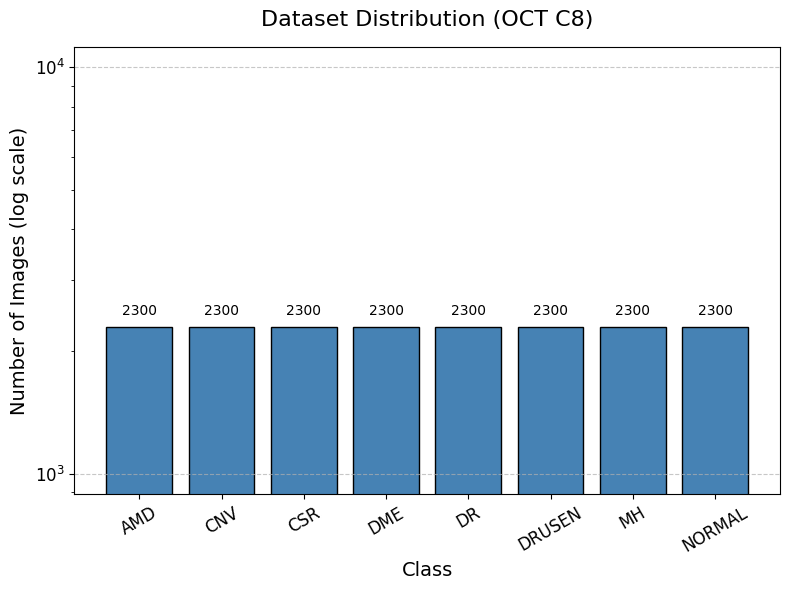

In [21]:
# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(dataset_dir, cls))) for cls in class_names}

# Plot bar chart (Research paper style)
plt.figure(figsize=(8,6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color="steelblue", edgecolor="black")

plt.yscale("log")  # log scale for imbalance datasets
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images (log scale)", fontsize=14)
plt.title("Dataset Distribution (OCT C8)", fontsize=16, pad=15)

# Light grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval*1.05, str(yval), 
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### Resizing effect

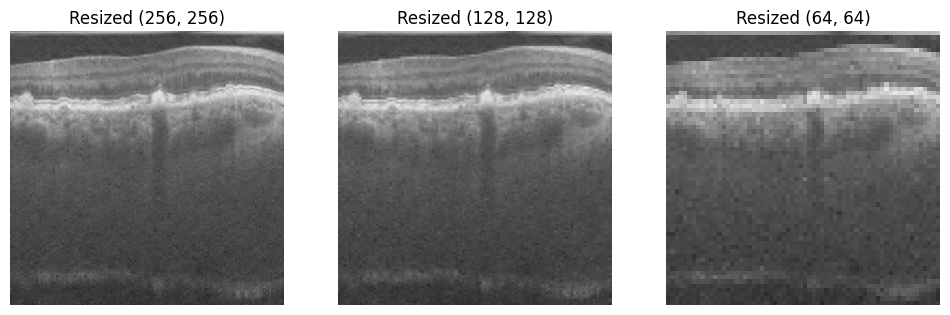

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick one sample image
sample_class = class_names[0]
sample_img_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])

# Different sizes
sizes = [(256,256), (128,128), (64,64)]
plt.figure(figsize=(12,4))

for i, size in enumerate(sizes):
    img = load_img(sample_img_path, target_size=size)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"Resized {size}")
    plt.axis("off")
plt.show()


### Effect of normalization/

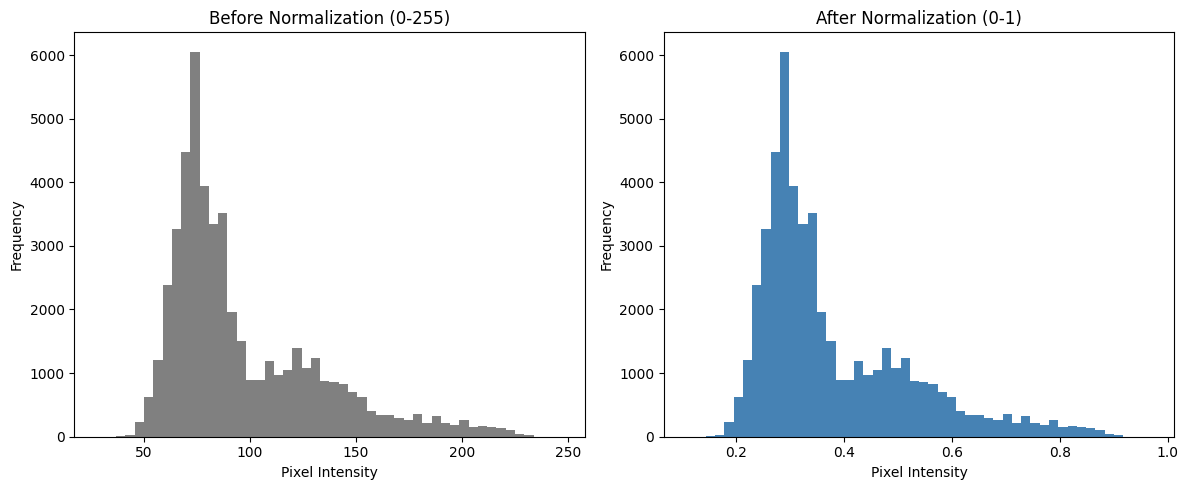

In [23]:
# Load image as array
img = load_img(sample_img_path, target_size=(128,128))
img_array = img_to_array(img)

# Before normalization
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(img_array.ravel(), bins=50, color="gray")
plt.title("Before Normalization (0-255)")
plt.xlabel("Pixel Intensity"); plt.ylabel("Frequency")

# After normalization
img_norm = img_array / 255.0
plt.subplot(1,2,2)
plt.hist(img_norm.ravel(), bins=50, color="steelblue")
plt.title("After Normalization (0-1)")
plt.xlabel("Pixel Intensity"); plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


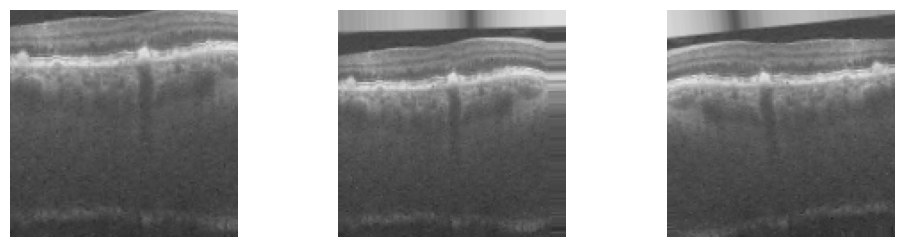

In [26]:
# Generate augmented samples
img = img_array.reshape((1,)+img_array.shape)

aug_iter = datagen.flow(img, batch_size=1)

plt.figure(figsize=(10,5))
for i in range(3):
    batch = next(aug_iter)
    aug_img = batch[0]
    plt.subplot(2,3,i+1)
    plt.imshow(aug_img)
    plt.axis("off")
    # plt.title("Augmented")
plt.tight_layout()
plt.show()


### Graphs for vgg19

In [29]:
# Cell 1: imports
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


In [31]:
hist = history.history

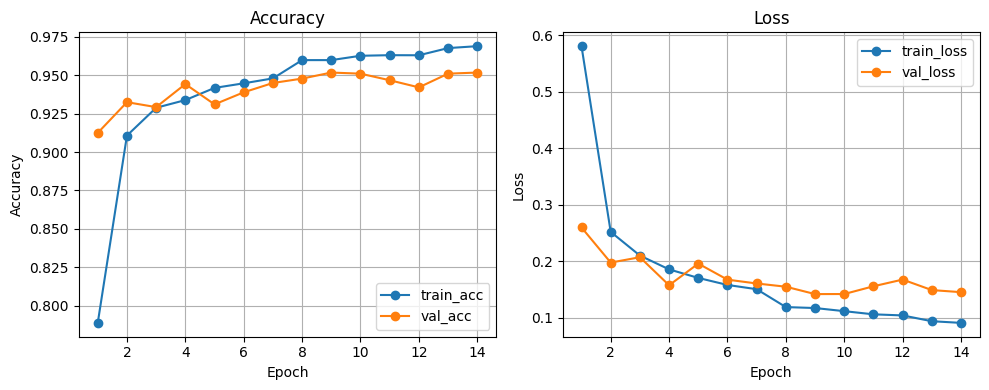

In [33]:
# Cell 2A: assuming `history` variable exists (returned by model.fit)
# history.history is a dict: e.g. 'accuracy', 'loss', 'val_accuracy', 'val_loss', maybe 'lr'

hist = history.history  # Keras History object

# Basic plots
epochs = np.arange(1, len(hist['loss']) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, hist['accuracy'], marker='o', label='train_acc')
plt.plot(epochs, hist.get('val_accuracy', []), marker='o', label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, hist['loss'], marker='o', label='train_loss')
plt.plot(epochs, hist.get('val_loss', []), marker='o', label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


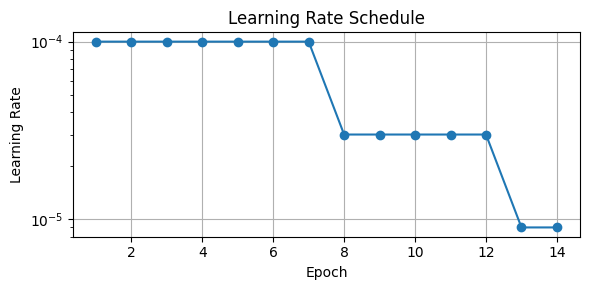

In [34]:
# Cell 3A: plot learning rate if available
lr_list = None

# 1) check history.history for 'lr' or 'learning_rate'
for key in ['lr', 'learning_rate', 'learning-rate']:
    if key in hist:
        lr_list = hist[key]
        break

# 2) If not available but optimizer is accessible, try reading learning rate (works only for current model state)
#    This will give only the final learning rate, not per-epoch. Keep it as fallback.
if lr_list is None:
    try:
        # model.optimizer.learning_rate can be a tensor/schedule; try to get its value
        lr_val = float(model.optimizer.learning_rate.numpy())
        lr_list = [lr_val] * len(epochs)
    except Exception:
        lr_list = None

if lr_list is not None:
    plt.figure(figsize=(6,3))
    plt.plot(epochs, lr_list, marker='o')
    plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate Schedule'); 
    plt.yscale('log'); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No per-epoch LR found in history. See the Record-LR callback (next cell) to capture LR in future runs.")


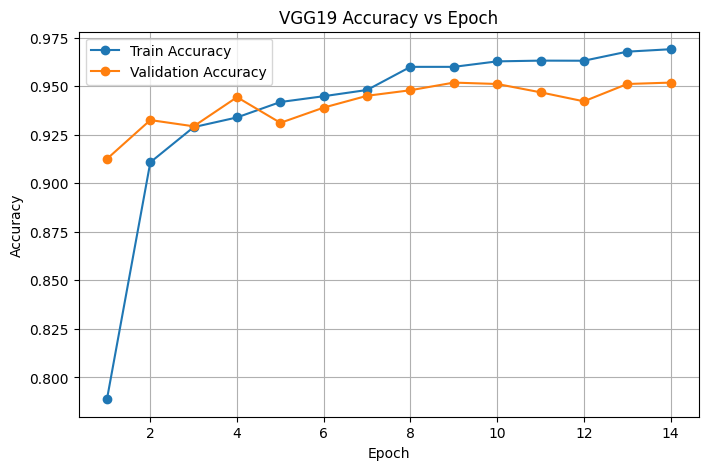

# ResNet model 

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [23]:

test_dir  = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test"
train_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train"
val_dir   = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val"

img_size = (224, 224)
batch_size = 32
num_classes = 8


In [24]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 18400 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


In [25]:
# Load ResNet50 without top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)  # 8 OCT classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 14,466,568 (55.19 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [26]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('resnet50_oct_best.h5', monitor='val_accuracy', save_best_only=True)
]


In [ ]:
epochs = 50  

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/50
292/575 ━━━━━━━━━━━━━━━━━━━━ 2:18 490ms/step - accuracy: 0.2348 - loss: 1.9541

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


In [18]:
import matplotlib.pyplot as plt

# From your logs
epochs = list(range(1, 46))

train_acc = [0.2913, 0.4743, 0.4877, 0.5102, 0.5367, 0.5463, 0.5658, 0.5692, 0.5871, 0.6062,
             0.6317, 0.6445, 0.6534, 0.6491, 0.6617, 0.6752, 0.6780, 0.6809, 0.6998, 0.6932,
             0.7139, 0.7296, 0.7535, 0.7429, 0.7430, 0.7522, 0.7581, 0.7687, 0.7666, 0.7767,
             0.7877, 0.7894, 0.7841, 0.7892, 0.7992, 0.7969, 0.7972, 0.8010, 0.8081, 0.8126,
             0.8071, 0.8027, 0.8086, 0.8134, 0.8161]

val_acc = [0.1396, 0.1575, 0.3393, 0.1846, 0.2007, 0.3611, 0.2743, 0.2454, 0.2554, 0.2250,
           0.4436, 0.3075, 0.4832, 0.4657, 0.4450, 0.3889, 0.7139, 0.6361, 0.4264, 0.6411,
           0.4457, 0.7529, 0.7646, 0.4914, 0.7818, 0.6736, 0.7171, 0.7836, 0.7921, 0.6514,
           0.8314, 0.8161, 0.8046, 0.8168, 0.7818, 0.8261, 0.8554, 0.8661, 0.8307, 0.8382,
           0.8443, 0.8407, 0.8271, 0.8421, 0.8371]

train_loss = [1.7998, 1.2269, 1.1689, 1.0981, 1.0602, 1.0334, 0.9887, 0.9871, 0.9578, 0.9140,
              0.8895, 0.8485, 0.8269, 0.8397, 0.8089, 0.7805, 0.7759, 0.7659, 0.7300, 0.7397,
              0.7060, 0.6612, 0.6212, 0.6352, 0.6306, 0.6171, 0.5916, 0.5740, 0.5763, 0.5549,
              0.5284, 0.5326, 0.5391, 0.5168, 0.5096, 0.5049, 0.5038, 0.4952, 0.4903, 0.4831,
              0.4830, 0.4917, 0.4820, 0.4768, 0.4614]

val_loss = [34.9226, 8.4226, 4.0696, 4.4887, 5.7402, 3.0079, 2.6988, 4.1675, 4.7730, 5.9040,
            2.6649, 8.5738, 2.7068, 2.2282, 3.5329, 10.9199, 0.6651, 1.0614, 6.0600, 0.9012,
            3.9766, 0.6167, 0.6022, 2.7668, 0.5152, 1.2288, 0.7570, 0.5518, 0.5501, 1.2051,
            0.4169, 0.4625, 0.5038, 0.4742, 0.5850, 0.4510, 0.3963, 0.3699, 0.4471, 0.4104,
            0.4005, 0.3992, 0.4410, 0.4026, 0.4064]


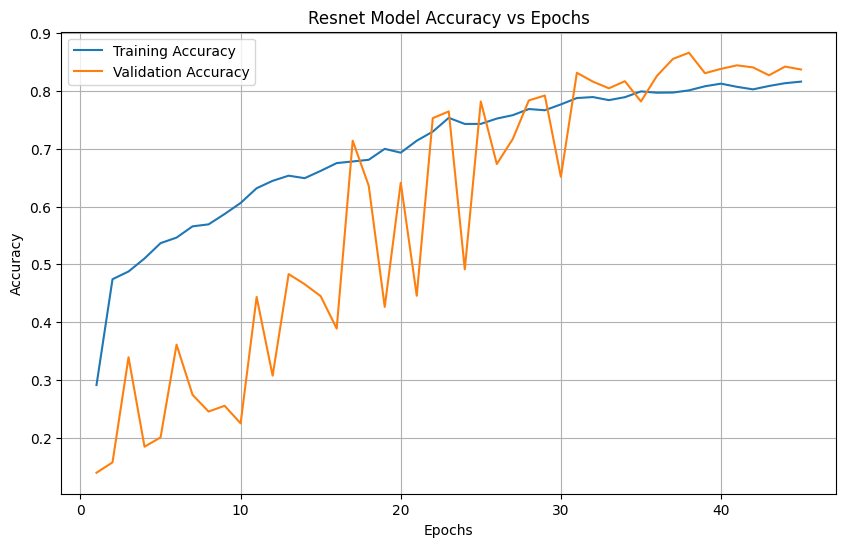

In [19]:
plt.figure(figsize=(10,6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Resnet Model Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


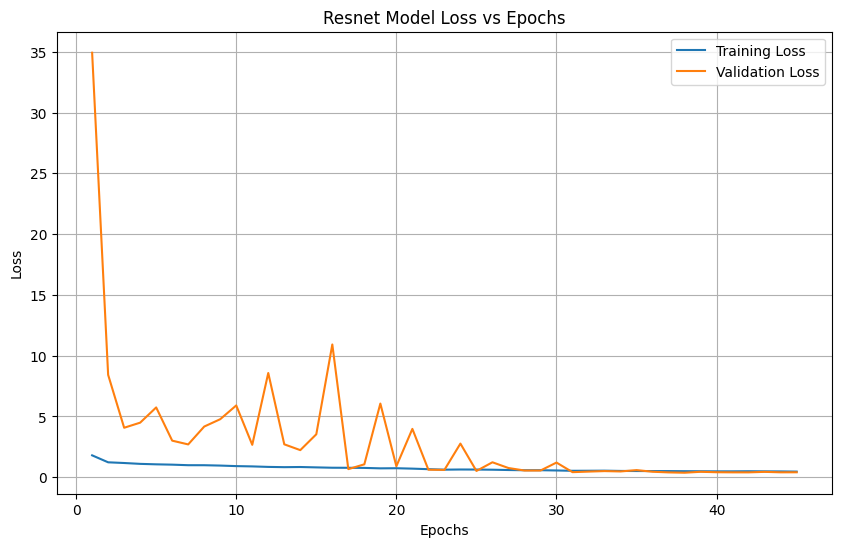

In [20]:
plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet Model Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


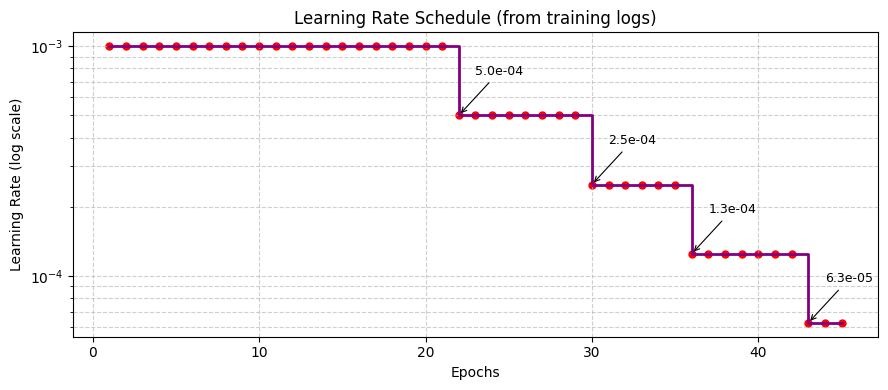

In [21]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(1, 46))

# LR schedule reconstructed from your logs
lr = [1e-3]*21 + [5e-4]*8 + [2.5e-4]*6 + [1.25e-4]*7 + [6.25e-5]*3

# Plot LR schedule
plt.figure(figsize=(9,4))
plt.step(epochs, lr, where='post', linewidth=2, color='purple')
plt.scatter(epochs, lr, s=25, color='red')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate (log scale)')
plt.title('Learning Rate Schedule (from training logs)')
plt.grid(which='both', linestyle='--', alpha=0.6)

# Annotate reduction points
reductions = [(22, lr[21]), (30, lr[29]), (36, lr[35]), (43, lr[42])]
for e, v in reductions:
    plt.annotate(f'{v:.1e}', xy=(e, v), xytext=(e+1, v*1.5),
                 arrowprops=dict(arrowstyle='->', lw=0.8), fontsize=9)

plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# ==========================
# SETTINGS
# ==========================
DATASET_DIR = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"   # <-- change this to your dataset root (contains train/test/val)
OUTPUT_DIR = "oct_embeddings"  # where CSVs will be saved
IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_LIMIT = None     # set e.g. 200 for quick test, None for full dataset
# ==========================

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load VGG19 (ImageNet weights, without top classifier, global average pooling)
base_model = VGG19(weights="imagenet", include_top=False, pooling="avg")
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_embeddings(split):
    """Extract embeddings for a dataset split (train/test/val)."""
    print(f"\n🔹 Processing split: {split}")
    data, labels = [], []

    split_dir = os.path.join(DATASET_DIR, split)
    classes = sorted(os.listdir(split_dir))

    for cls in classes:
        class_dir = os.path.join(split_dir, cls)
        files = os.listdir(class_dir)

        if BATCH_LIMIT:  # for quick testing
            files = files[:BATCH_LIMIT]

        for file in tqdm(files, desc=f"Class {cls}"):
            img_path = os.path.join(class_dir, file)
            try:
                # Load + preprocess
                img = load_img(img_path, target_size=IMG_SIZE)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                # Extract features
                feat = model.predict(x, verbose=0)
                data.append(feat.flatten())
                labels.append(cls)
            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

    # Save to CSV
    df = pd.DataFrame(data)
    df["label"] = labels
    out_path = os.path.join(OUTPUT_DIR, f"{split}_embeddings.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Saved embeddings: {out_path}")

# Run for all splits
for split in ["train", "test", "val"]:
    extract_embeddings(split)

print("\n🎉 All embeddings generated! Load the CSVs into Orange for training.")


2025-09-12 15:21:14.348022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757690474.541492      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757690474.597329      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1757690486.504674      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

🔹 Processing split: train


Class AMD:   0%|          | 0/2300 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1757690492.911050      98 service.cc:148] XLA service 0x7a75a400af40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757690492.911736      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757690493.049760      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757690494.562448      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Class NORMAL: 100%|██████████| 2300/2300 [03:16<00:00, 11.68it/s]


✅ Saved embeddings: oct_embeddings/train_embeddings.csv

🔹 Processing split: test


Class NORMAL: 100%|██████████| 350/350 [00:30<00:00, 11.37it/s]


✅ Saved embeddings: oct_embeddings/test_embeddings.csv

🔹 Processing split: val


Class NORMAL: 100%|██████████| 350/350 [00:29<00:00, 11.84it/s]


✅ Saved embeddings: oct_embeddings/val_embeddings.csv

🎉 All embeddings generated! Load the CSVs into Orange for training.


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# ==========================
# SETTINGS
# ==========================
DATASET_DIR = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"   # <-- change this to your dataset root (contains train/test/val)
OUTPUT_DIR = "oct_embeddings_resnet"  # new folder for ResNet embeddings
IMG_SIZE = (224, 224)  # ResNet input size
BATCH_LIMIT = None     # set e.g. 200 for quick test, None for full dataset
# ==========================

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load ResNet50 (ImageNet weights, without top classifier, global average pooling)
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_embeddings(split):
    """Extract embeddings for a dataset split (train/test/val)."""
    print(f"\n🔹 Processing split: {split}")
    data, labels = [], []

    split_dir = os.path.join(DATASET_DIR, split)
    classes = sorted(os.listdir(split_dir))

    for cls in classes:
        class_dir = os.path.join(split_dir, cls)
        files = os.listdir(class_dir)

        if BATCH_LIMIT:  # for quick testing
            files = files[:BATCH_LIMIT]

        for file in tqdm(files, desc=f"Class {cls}"):
            img_path = os.path.join(class_dir, file)
            try:
                # Load + preprocess
                img = load_img(img_path, target_size=IMG_SIZE)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                # Extract features
                feat = model.predict(x, verbose=0)
                data.append(feat.flatten())
                labels.append(cls)
            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

    # Save to CSV
    df = pd.DataFrame(data)
    df["label"] = labels
    out_path = os.path.join(OUTPUT_DIR, f"{split}_embeddings.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Saved embeddings: {out_path}")

# Run for all splits
for split in ["train", "test", "val"]:
    extract_embeddings(split)

print("\n🎉 All embeddings generated with ResNet50! Load the CSVs into Orange for training.")


2025-09-12 17:17:33.384276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757697453.558625      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757697453.613405      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1757697466.457201      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

🔹 Processing split: train


Class AMD:   0%|          | 0/2300 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1757697472.759876      95 service.cc:148] XLA service 0x7eb024001c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757697472.760822      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757697473.379752      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757697475.616670      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Class NORMAL: 100%|██████████| 2300/2300 [03:38<00:00, 10.50it/s]


✅ Saved embeddings: oct_embeddings_resnet/train_embeddings.csv

🔹 Processing split: test


Class NORMAL: 100%|██████████| 350/350 [00:34<00:00, 10.17it/s]


✅ Saved embeddings: oct_embeddings_resnet/test_embeddings.csv

🔹 Processing split: val


Class NORMAL: 100%|██████████| 350/350 [00:33<00:00, 10.49it/s]


✅ Saved embeddings: oct_embeddings_resnet/val_embeddings.csv

🎉 All embeddings generated with ResNet50! Load the CSVs into Orange for training.
